In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tables
import h5py

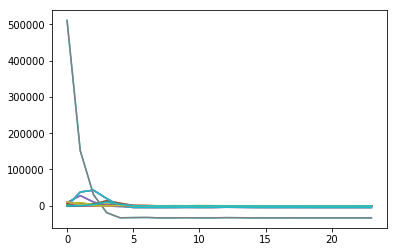

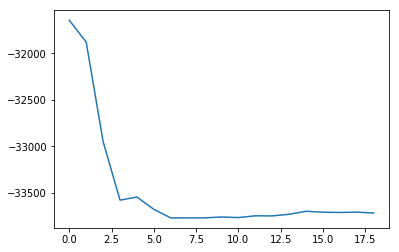

In [40]:
h = tables.open_file('../coeff_pe_1t_2.0MeV_dns_aic/file_0.580.h5')
k = []
for i in np.arange(1,25):
    d = eval('h.root.AIC%d[:]' % i)
    k.append(d)
k = np.array(k)
plt.plot(k - np.mean(k,axis=0))
plt.show()
plt.plot(k[5:,1])
plt.show()

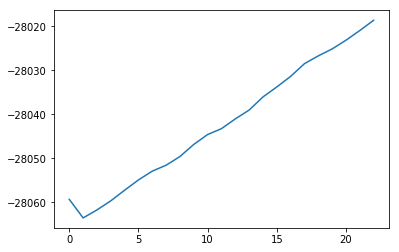